In [ ]:
#Dependencies installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
amazon_data_path = r"/content/drive/MyDrive/QML-Research/Data/sentiment labelled sentences/amazon_cells_labelled.txt"
with open(amazon_data_path, "r") as f:
  lines = f.readlines()

data = [line.strip().split("\t") for line in lines]
sentences, labels = zip(*data)
labels = np.array(labels, dtype = int)

In [ ]:
tokenized_sents = [sentence.lower().split() for sentence in sentences]
word_counts = Counter(word for sentence in tokenized_sents for word in sentence)
vocab = {word: i+1 for i, (word, _) in enumerate(word_counts.items())}
encoded_sents = [[vocab[word] for word in sentence] for sentence in tokenized_sents]

In [ ]:
max_len = max(len(sentence) for sentence in encoded_sents)
min_len = min(len(sentence) for sentence in encoded_sents)
sentence_lengths = [len(sentence) for sentence in encoded_sents]
nintyfive = int(np.percentile(sentence_lengths, 95))
print(f"Max length: {max_len}\nMin length: {min_len}")
print(f"95th percentile: {nintyfive}")

Max length: 30
Min length: 1
95th percentile: 23


In [ ]:
def pad_and_truncate(seq, pad_len):
  return seq[:pad_len] + [0]*max(0, pad_len - len(seq))

padded_sents = [pad_and_truncate(sent, nintyfive) for sent in encoded_sents]
print(f"Number of sentences: {len(padded_sents)}")
print(f"First Sample: {padded_sents[0]}")

Number of sentences: 1000
First Sample: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 11, 13, 14, 15, 16, 17, 18, 19, 20, 0, 0]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sents, labels, test_size = 0.2, random_state = 42)
X_train, X_test, y_train, y_test = map(torch.tensor, (X_train, X_test, y_train, y_test))

In [ ]:
print(X_train[:5])
print()
print(X_test[:5])

tensor([[ 206,  207,  208,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 145,   10, 1550,   80,   60, 1551,   85,  320,  442, 1552, 1553,   13,
         1554, 1555,   75,   10,   80, 1556,  597,  108,   82,   75,   16],
        [ 122,  108,  278,   46,   47,  274,    8,  153,   13, 1948,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  16,   38,  423,  352,    6,  481, 1615,   75, 1616,   75,  145, 1617,
          275, 1319,   75,  460,   56,  153,    0,    0,    0,    0,    0],
        [1534,  890, 2243,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

tensor([[1524, 1332,    8, 1084,    6, 1183,   13, 1525,   16,  237,    6,   19,
           21, 1462,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  13, 2063,    3, 1440, 2064,   75,  133,   10,

In [ ]:
print(f"Total Samples: {len(sentences)}")
print(f"Positive Samples: {sum(labels)}")
print(f"Negative Samples: {len(labels) - sum(labels)}")

Total Samples: 1000
Positive Samples: 500
Negative Samples: 500


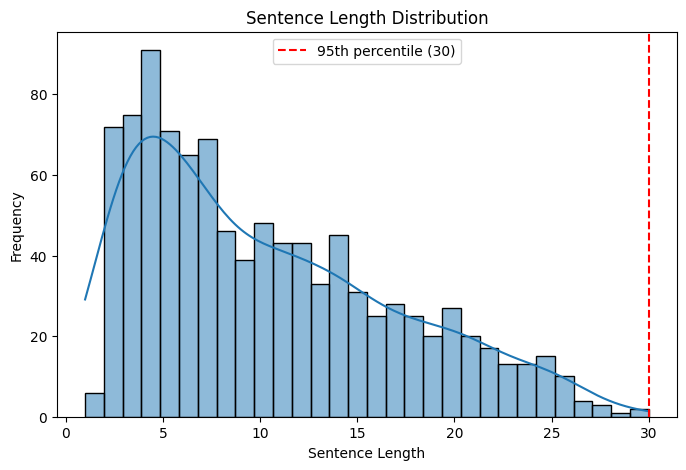

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.axvline(max_len, color='red', linestyle='dashed', label=f'95th percentile ({max_len})')
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribution")
plt.legend()
plt.show()

In [ ]:
most_common_words = word_counts.most_common(10)
print("Most common words:", most_common_words)

Most common words: [('the', 513), ('i', 313), ('and', 310), ('is', 238), ('it', 237), ('a', 217), ('this', 197), ('to', 195), ('my', 143), ('for', 119)]


In [ ]:
def get_dataloader(X, y, batch_size=32):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_loader = get_dataloader(X_train, y_train)
test_loader = get_dataloader(X_test, y_test)

In [ ]:
class ManualRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_matrix=None):
        super(ManualRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) if embedding_matrix is not None else nn.Embedding(vocab_size, embedding_dim)

        self.Wi = nn.Parameter(torch.randn(embedding_dim, hidden_dim) * 0.01)
        self.Wh = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.bh = nn.Parameter(torch.zeros(hidden_dim))

        self.fc = nn.Linear(hidden_dim, target_size)

    def forward(self, x):
        batch_size, seq_len = x.shape
        h = torch.zeros(batch_size, self.hidden_dim)
        embeds = self.embedding(x)

        for t in range(seq_len):
            h = torch.tanh(embeds[:, t] @ self.Wi + h @ self.Wh + self.bh)

        output = self.fc(h)
        return output

In [ ]:
class ManualBiRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_matrix=None):
        super(ManualBiRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) if embedding_matrix is not None else nn.Embedding(vocab_size, embedding_dim)

        self.Wi_f = nn.Parameter(torch.randn(embedding_dim, hidden_dim) * 0.01)
        self.Wh_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.bh_f = nn.Parameter(torch.zeros(hidden_dim))

        self.Wi_b = nn.Parameter(torch.randn(embedding_dim, hidden_dim) * 0.01)
        self.Wh_b = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.bh_b = nn.Parameter(torch.zeros(hidden_dim))

        self.fc = nn.Linear(hidden_dim * 2, target_size)

    def forward(self, x):
        batch_size, seq_len = x.shape
        h_f = torch.zeros(batch_size, self.hidden_dim)
        h_b = torch.zeros(batch_size, self.hidden_dim)
        embeds = self.embedding(x)

        # Forward RNN pass
        for t in range(seq_len):
            h_f = torch.tanh(embeds[:, t] @ self.Wi_f + h_f @ self.Wh_f + self.bh_f)

        # Backward RNN pass
        for t in reversed(range(seq_len)):
            h_b = torch.tanh(embeds[:, t] @ self.Wi_b + h_b @ self.Wh_b + self.bh_b)

        h_combined = torch.cat([h_f, h_b], dim=1)
        output = self.fc(h_combined)
        return output


In [ ]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Evaluation on test set
        model.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

In [ ]:
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vocab_size = len(vocab) + 1
embedding_dim = 100
hidden_dim = 64
output_dim = 2
criterion = nn.CrossEntropyLoss()

In [ ]:
rnn_model = ManualRNN(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.001)
rnn_results = train_and_evaluate(rnn_model, train_loader, test_loader, nn.CrossEntropyLoss(), optimizer_rnn, num_epochs=100, device=device)

Epoch 1/100 - Train Loss: 0.7005, Train Acc: 0.4925, Test Loss: 0.6865, Test Acc: 0.5400
Epoch 2/100 - Train Loss: 0.7025, Train Acc: 0.4763, Test Loss: 0.7043, Test Acc: 0.4950
Epoch 3/100 - Train Loss: 0.6939, Train Acc: 0.5150, Test Loss: 0.7054, Test Acc: 0.4500
Epoch 4/100 - Train Loss: 0.6806, Train Acc: 0.5413, Test Loss: 0.6994, Test Acc: 0.5200
Epoch 5/100 - Train Loss: 0.6667, Train Acc: 0.5513, Test Loss: 0.7069, Test Acc: 0.4950
Epoch 6/100 - Train Loss: 0.6557, Train Acc: 0.5837, Test Loss: 0.7097, Test Acc: 0.5100
Epoch 7/100 - Train Loss: 0.6337, Train Acc: 0.5950, Test Loss: 0.7270, Test Acc: 0.4950
Epoch 8/100 - Train Loss: 0.6047, Train Acc: 0.6663, Test Loss: 0.7442, Test Acc: 0.4800
Epoch 9/100 - Train Loss: 0.5738, Train Acc: 0.7188, Test Loss: 0.9227, Test Acc: 0.4850
Epoch 10/100 - Train Loss: 0.5152, Train Acc: 0.7588, Test Loss: 0.7912, Test Acc: 0.5200
Epoch 11/100 - Train Loss: 0.4670, Train Acc: 0.8125, Test Loss: 1.0068, Test Acc: 0.4900
Epoch 12/100 - Trai

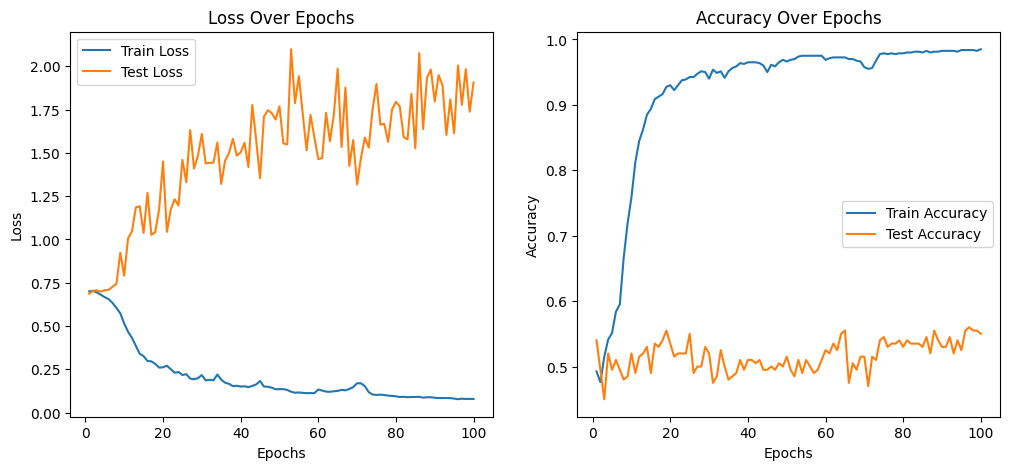

In [ ]:
plot_metrics(*rnn_results)

In [ ]:
birnn_model = ManualBiRNN(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
optimizer_birnn = optim.Adam(birnn_model.parameters(), lr=0.001)
birnn_results = train_and_evaluate(birnn_model, train_loader, test_loader, nn.CrossEntropyLoss(), optimizer_birnn, num_epochs=100, device=device)

Epoch 1/100 - Train Loss: 0.6883, Train Acc: 0.5463, Test Loss: 0.6420, Test Acc: 0.6450
Epoch 2/100 - Train Loss: 0.5986, Train Acc: 0.6550, Test Loss: 0.5854, Test Acc: 0.6750
Epoch 3/100 - Train Loss: 0.5291, Train Acc: 0.7288, Test Loss: 0.6138, Test Acc: 0.6850
Epoch 4/100 - Train Loss: 0.4646, Train Acc: 0.7837, Test Loss: 0.5937, Test Acc: 0.7200
Epoch 5/100 - Train Loss: 0.4006, Train Acc: 0.8187, Test Loss: 0.5725, Test Acc: 0.7200
Epoch 6/100 - Train Loss: 0.3229, Train Acc: 0.8638, Test Loss: 0.6156, Test Acc: 0.7250
Epoch 7/100 - Train Loss: 0.2547, Train Acc: 0.9025, Test Loss: 0.6184, Test Acc: 0.7450
Epoch 8/100 - Train Loss: 0.2207, Train Acc: 0.9150, Test Loss: 0.6222, Test Acc: 0.7400
Epoch 9/100 - Train Loss: 0.1587, Train Acc: 0.9475, Test Loss: 0.6458, Test Acc: 0.7400
Epoch 10/100 - Train Loss: 0.1256, Train Acc: 0.9600, Test Loss: 0.8999, Test Acc: 0.7550
Epoch 11/100 - Train Loss: 0.0711, Train Acc: 0.9825, Test Loss: 0.8346, Test Acc: 0.7600
Epoch 12/100 - Trai

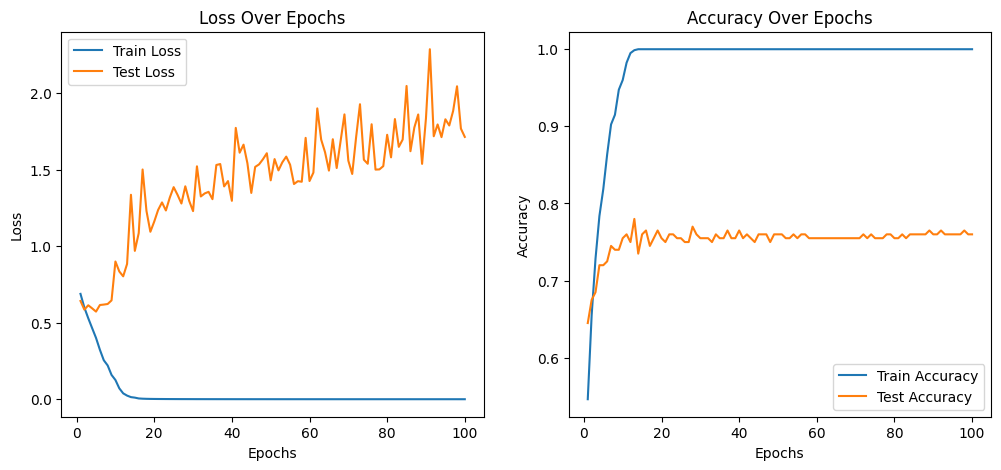

In [ ]:
plot_metrics(*birnn_results)